In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
import cvxpy as cp
from scipy.optimize import minimize

In [2]:
df_0=pd.read_csv(r'code\TRD_Dalyr.csv')
df_1=pd.read_csv(r'code\TRD_Dalyr1.csv')
df_2=pd.read_csv(r'code\TRD_Dalyr2.csv')
df_3=pd.read_csv(r'code\TRD_Dalyr3.csv')

In [3]:
data=pd.concat([df_0,df_1,df_2,df_2],axis=0)
data.columns=['code','time','return']

In [4]:
data_pivot=data.pivot_table(index='time',columns='code',values='return')
data_pivot.dropna(how='any',axis=1,inplace=True)

In [5]:
mu=data_pivot.mean().to_numpy()
Sigma=data_pivot.cov()
Sigma=Sigma.to_numpy()

In [6]:
@jit
def compute(var_num,n):
    p_mean_list=[]
    p_std_list=[]
    for i in range(n):
        weights=np.random.random(var_num)
        weights=weights/np.sum(weights)

        p_mean=weights@mu
        p_std=np.sqrt(weights@Sigma@weights)

        p_mean_list.append(p_mean)
        p_std_list.append(p_std)
    return p_mean_list,p_std_list

In [8]:
p_mean_list,p_std_list=compute(mu.shape[0],100_000)

In [9]:
p_mean_list=np.array(p_mean_list)*252
p_std_list=np.array(p_std_list)*np.sqrt(252)

In [179]:
def std(weights):
    return np.sqrt(weights@Sigma@weights)

min_mean_list=np.arange(0.0003,0.0006,0.00002)
min_std_list=[]

for mean in min_mean_list:
    weights=np.random.randn(mu.shape[0])
    weights=weights/np.sum(weights)

    bounds=tuple((0,1) for i in range(mu.shape[0]))

    constraints=[{'type':'eq','fun':lambda weights:np.sum(weights)-1},{'type':'eq','fun':lambda weights:weights@mu-mean}]

    outcome=minimize(std,x0=weights,constraints=constraints,bounds=bounds)
    min_std_list.append(outcome.fun)

In [21]:
min_mean_list=np.arange(0.105,0.130,0.002)
min_std_list=np.array([0.23043,0.2298,0.2294,0.2290,0.2288,0.2287,0.2288,0.2291,0.2294,0.2298,0.2305,0.2318,0.2332])

rf=0.023
sharpe_list=(min_mean_list-rf)/min_std_list

min_portfolio=np.array([min_std_list,min_mean_list,sharpe_list]).reshape(3,-1).transpose()

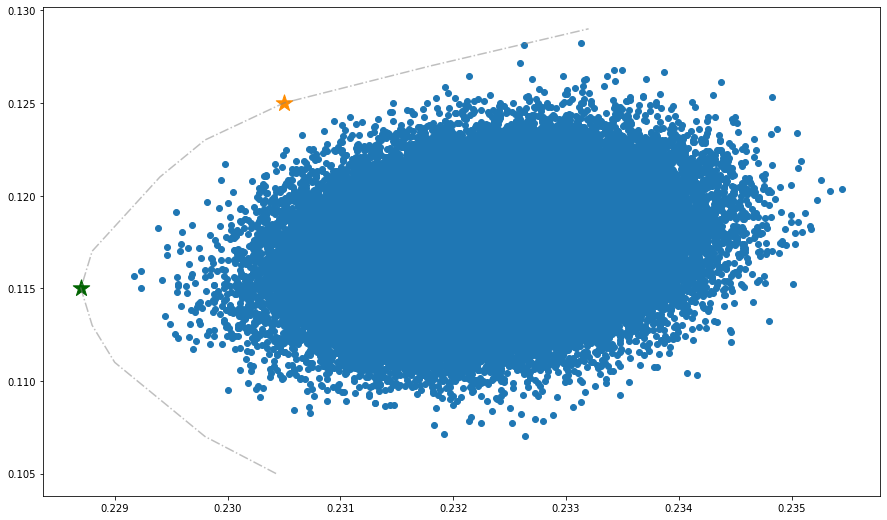

In [43]:
fig,ax=plt.subplots(figsize=[15,9])
ax.scatter(p_std_list,p_mean_list)
ax.plot(min_std_list,min_mean_list,color='gray',ls='-.',alpha=0.5)
ax.scatter(0.2305,0.125,color='darkorange',marker='*',s=300)
ax.scatter(0.2287,0.115,color='darkgreen',marker='*',s=300)
plt.show()